### Loading Libraries

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


import sklearn
from sklearn import preprocessing

### NLP Libraries
import string
import re
from nltk.tokenize import  word_tokenize 
import nltk
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
stpwords = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
pd.options.display.max_colwidth = 500


### Importing TensorFlow Libraries

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Bidirectional, Multiply, Lambda
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import keras.backend as K

## Importing Word2Vec Embeddings

import gensim
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from gensim.models import KeyedVectors
filename = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'
w2v_dictionary = KeyedVectors.load_word2vec_format(filename, binary=True)

# if glove file is on your google drive and you are running the notebook on colab, run this code below, else ignore


### Importing Glove Embeddings
#path = '/content/drive/My Drive/glove.6B.200d.txt'
### Loading Glove vectors
  # g_dictionary = {}
  # with open(path) as file:
  #   for each_line in file:
  #       words_in_line, coeff_cients = each_line.split(maxsplit=1)
  #       coeff_cients = np.array(coeff_cients.split(),dtype = float)
  #       glove_dictionary[words_in_line] = coeff_cients


Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
def clean_message(text):
    '''Function to clean and preprocess the input text'''

    text = re.sub("'", "", text) # to avoid removing contractions in english
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'\'s', '', text)
    text = re.sub(r'<br />', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)
    text = text.lower()
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed) if word not in stpwords])
    #text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)])
    text = " ".join([lemmatizer.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text
        
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

def exponent_neg_euclidean_distance(left, right):
    return K.exp(-(K.sqrt(K.sum(K.square(left-right), axis=1, keepdims=True))))


### Loading Dataset

In [3]:
### Importing Dataset

data_org = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone Quora Question Pairs/train.csv")
data_org = data_org.dropna()
print(data_org.shape)
data_org.head()

(404287, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [4]:
#data = data_org.sample(50000)
data = data_org.copy()
data.shape

(404287, 6)

In [5]:
data['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [6]:

### Cleaning Question 1 and Question 2
data['question1'] = data['question1'].apply(clean_message)
data['question2'] = data['question2'].apply(clean_message)

In [7]:
### Getting a count of the number of unique words in the dataset

temp = list(data['question1'].str.split(' ', expand=True).stack().unique())
temp.extend(list(data['question2'].str.split(' ', expand=True).stack().unique()))
len(set(temp)) #max words

82822

In [8]:
### Preprocessing the Dataset

max_words = len(set(temp))
print("\n### CLEANING DATASET ###")

data = data[data['question2'].apply(lambda x: str(x)!= "")]
data = data[data['question1'].apply(lambda x: str(x)!= "")]

print('Shape of dataset after cleaning', data.shape)

print("\n### TRAIN - TEST SPLIT ###")

x1 = data['question1']
x2 = data['question2']
y = data['is_duplicate']

x_train1, x_test1, y_train, y_test = train_test_split(x1,y,test_size=0.2, random_state=100)
x_train2, x_test2, y_train, y_test = train_test_split(x2,y,test_size=0.2, random_state=100)

print('Shape of x_train1',x_train1.shape)
print('Shape of x_test1',x_test1.shape)
print('Shape of x_train2',x_train1.shape)
print('Shape of x_test2',x_test1.shape)
print('Shape of y_train',y_train.shape)
print('Shape of x_test',y_test.shape)


### CLEANING DATASET ###
Shape of dataset after cleaning (404279, 6)

### TRAIN - TEST SPLIT ###
Shape of x_train1 (323423,)
Shape of x_test1 (80856,)
Shape of x_train2 (323423,)
Shape of x_test2 (80856,)
Shape of y_train (323423,)
Shape of x_test (80856,)


In [9]:
### Deleting temporary variables to clear memory
temp = None
x1 = None
x2 = None
y = None

In [10]:
## Embedding, tokenizing and padding the texts

print("\n### EMBEDDING TEXTS ###")
# Max number of words in each question
max_seq = max(max(x_train1.apply(lambda x:len(x))),max(x_train2.apply(lambda x:len(x))))
print(max_seq)

max_words = 20000

### Tokenizing
tokenizer = Tokenizer(num_words=max_words,oov_token="<OOV>")
tokenizer.fit_on_texts(list(x_train1.astype(str))+list(x_train2.values.astype(str)))
word_index = tokenizer.word_index

### Converting Texts to sequences
vocabulary = list(word_index.keys())
x_train1 = tokenizer.texts_to_sequences(x_train1)
x_test1 = tokenizer.texts_to_sequences(x_test1)
x_train1 = pad_sequences(x_train1, maxlen = max_seq)
x_test1 = pad_sequences(x_test1, maxlen = max_seq)

x_train2 = tokenizer.texts_to_sequences(x_train2)
x_test2 = tokenizer.texts_to_sequences(x_test2)
x_train2 = pad_sequences(x_train2, maxlen = max_seq)
x_test2 = pad_sequences(x_test2, maxlen = max_seq)

### Creating embedding matrix
embedding_matrix = np.zeros((len(vocabulary), 300))

for word,index in word_index.items():
    try: 
        embedding_matrix[index,:] = w2v_dictionary[word]
    except:
        pass



print("\n ### Shape after embeddings ###")

print('Shape of x_train1',np.array(x_train1).shape)
print('Shape of x_test1',np.array(x_test1).shape)
print('Shape of x_train2',np.array(x_train2).shape)
print('Shape of x_test2',np.array(x_test2).shape)
print('Shape of y_train',np.array(y_train).shape)
print('Shape of x_test',np.array(y_test).shape)




### EMBEDDING TEXTS ###
681

 ### Shape after embeddings ###
Shape of x_train1 (323423, 681)
Shape of x_test1 (80856, 681)
Shape of x_train2 (323423, 681)
Shape of x_test2 (80856, 681)
Shape of y_train (323423,)
Shape of x_test (80856,)


In [11]:
import pickle
with open('quora_question_pairs_w2v_tokenizer.pkl', 'wb') as fp:
        pickle.dump(tokenizer, fp)
fp.close()
with open('quora_question_pairs_w2v_embedding_matrix.pkl', 'wb') as fp:
        pickle.dump(embedding_matrix, fp)
fp.close()

In [29]:
tf.random.set_seed(42)

def build_model(embedding_matrix):
  
  model_q1 = tf.keras.Sequential()
  model_q1.add(Embedding(input_dim = len(word_index),
                        output_dim = 300,
                         input_length=max_seq,
                        weights = [embedding_matrix]))
  #model_q1.add(Bidirectional(LSTM(128, activation = 'relu')))
  model_q1.add(LSTM(128, activation = 'relu'))
  #model_q1.add(Dropout(0.2))
  #model_q1.add(Dense(64, activation = 'relu'))
  #model_q1.add(Dropout(0.2))
  #model_q1.add(Dense(32, activation = 'relu'))
  #model_q1.add(Dropout(0.2))
  #model_q1.add(Dense(16, activation = 'relu'))
  #model_q1.add(Dense(2, activation = 'sigmoid'))


  model_q2 = tf.keras.Sequential()
  model_q2.add(Embedding(input_dim = len(word_index),
                        output_dim = 300,
                         input_length=max_seq,
                        weights = [embedding_matrix]))
  #model_q2.add(Bidirectional(LSTM(128, activation = 'relu')))
  model_q2.add(LSTM(128, activation = 'relu'))
  #model_q2.add(Dropout(0.2))
  #model_q2.add(Dense(64, activation = 'relu'))
  #model_q2.add(Dropout(0.2))
  #model_q2.add(Dense(32, activation = 'relu'))
  #model_q2.add(Dropout(0.2))
  #model_q2.add(Dense(16, activation = 'relu'))
  #model_q2.add(Dense(2, activation = 'sigmoid'))

  malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([model_q1.output, model_q2.output])

  new_model = Model([model_q1.input, model_q2.input], malstm_distance)
  new_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'mean_squared_error',
                 metrics = ['accuracy','Precision','Recall'])
  return new_model

In [30]:
model = build_model(embedding_matrix)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_4_input (InputLayer)  [(None, 681)]       0           []                               
                                                                                                  
 embedding_5_input (InputLayer)  [(None, 681)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 681, 300)     22505100    ['embedding_4_input[0][0]']      
                                                                                                  
 embedding_5 (Embedding)        (None, 681, 300)     22505100    ['embedding_5_input[0][0]']      
                                                                                            

In [31]:
### Training the LSTM Model

LSTM_model = model.fit([x_train1,x_train2],y_train, validation_data=([x_test1,x_test2], y_test), batch_size = 512, epochs = 3)

Epoch 1/3
632/632 [==============================] - 1085s 2s/step - loss: 0.2136 - accuracy: 0.6939 - precision: 0.7088 - recall: 0.2912 - val_loss: 0.1800 - val_accuracy: 0.7383 - val_precision: 0.7286 - val_recall: 0.4607
Epoch 2/3
632/632 [==============================] - 1060s 2s/step - loss: 0.1698 - accuracy: 0.7557 - precision: 0.7432 - recall: 0.5177 - val_loss: 0.1674 - val_accuracy: 0.7588 - val_precision: 0.7397 - val_recall: 0.5322
Epoch 3/3
632/632 [==============================] - 1063s 2s/step - loss: 0.1571 - accuracy: 0.7777 - precision: 0.7572 - recall: 0.5862 - val_loss: 0.1615 - val_accuracy: 0.7675 - val_precision: 0.7364 - val_recall: 0.5736


In [32]:
### Prediting on test data for calculating performance metrics

preds = model.predict([x_test1,x_test2])

2527/2527 [==============================] - 508s 201ms/step


In [33]:
## Converting probability values to 0,1
preds_masked = np.where(preds > 0.5, 1, 0)

In [34]:
## Printing Results
print(classification_report(y_test,preds_masked))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83     51092
           1       0.74      0.57      0.64     29764

    accuracy                           0.77     80856
   macro avg       0.76      0.73      0.74     80856
weighted avg       0.76      0.77      0.76     80856



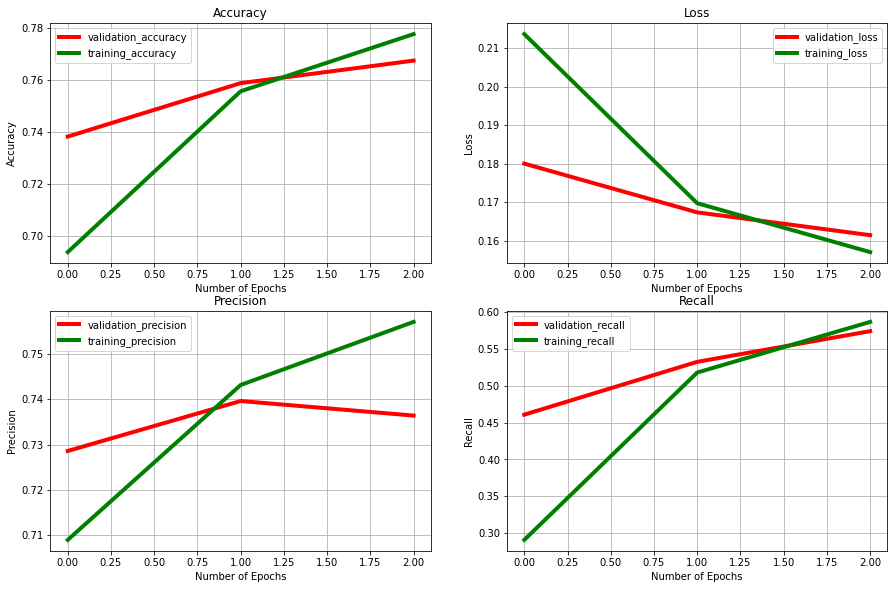

In [35]:
### PLotting the training and validation scores across epochs. 

import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(LSTM_model.history["val_accuracy"], label="validation_accuracy", c="red", linewidth=4)
plt.plot(LSTM_model.history["accuracy"], label="training_accuracy", c="green", linewidth=4)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(LSTM_model.history["val_loss"], label="validation_loss", c="red", linewidth=4)
plt.plot(LSTM_model.history["loss"], label="training_loss", c="green", linewidth=4)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)


plt.subplot(3,2,3)
plt.plot(LSTM_model.history["val_precision"], label="validation_precision", c="red", linewidth=4)
plt.plot(LSTM_model.history["precision"], label="training_precision", c="green", linewidth=4)
plt.xlabel("Number of Epochs")
plt.ylabel("Precision")
plt.title("Precision")
plt.legend()
plt.grid(True)


plt.subplot(3,2,4)
plt.plot(LSTM_model.history["val_recall"], label="validation_recall", c="red", linewidth=4)
plt.plot(LSTM_model.history["recall"], label="training_recall", c="green", linewidth=4)
plt.xlabel("Number of Epochs")
plt.ylabel("Recall")
plt.title("Recall")
plt.legend()
plt.grid(True)


plt.show()




In [36]:
import pickle

In [37]:
import pickle
with open('quora_question_pairs_w2v_lstm.pkl', 'wb') as fp:
        pickle.dump(model, fp)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......embedding
.........vars
............0
......embedding_1
.........vars
............0
......input_layer
.........vars
......input_layer_1
.........vars
......lambda
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......precision
.........vars
............0
............1
......recall
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                 

In [38]:

colab_link = "/content/quora_question_pairs_w2v_lstm.pkl"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/quora_question_pairs_w2v_lstm.pkl'

In [13]:
import shutil
colab_link = "/content/quora_question_pairs_w2v_tokenizer.pkl"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

colab_link = "/content/quora_question_pairs_w2v_embedding_matrix.pkl"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/quora_question_pairs_w2v_embedding_matrix.pkl'